### 2.2.1 Data Pre-Processing

In [35]:
# i) Load data into python and print information about the dataframe.
import pandas as pd

data = pd.read_csv("abalone.data")

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   M       4176 non-null   object 
 1   0.455   4176 non-null   float64
 2   0.365   4176 non-null   float64
 3   0.095   4176 non-null   float64
 4   0.514   4176 non-null   float64
 5   0.2245  4176 non-null   float64
 6   0.101   4176 non-null   float64
 7   0.15    4176 non-null   float64
 8   15      4176 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


In [36]:
# ii) Assign exact column names to dataframe 
data.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

In [37]:
# iii) Check missing values.
data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [38]:
# iv) Perform one-hot encoding to ’sex’.
data = pd.get_dummies(data, columns=['Sex'], prefix='Sex') 

In [39]:
# v) Perform min-max normalisation on numerical variables(exclude target variable ’Rings’)

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.difference(['Rings'])

# Min-Max normalization
data[numerical_columns] = (data[numerical_columns] - data[numerical_columns].min()) / (data[numerical_columns].max() - data[numerical_columns].min())

In [40]:
# vi) Transform target variable: (’Rings’+ 1.5 = Age (yrs)) and remove ’Rings’ in dataframe

data['Age (yrs)'] = data['Rings'] + 1.5

# Drop the 'Rings' column
data.drop(columns=['Rings'], inplace=True)

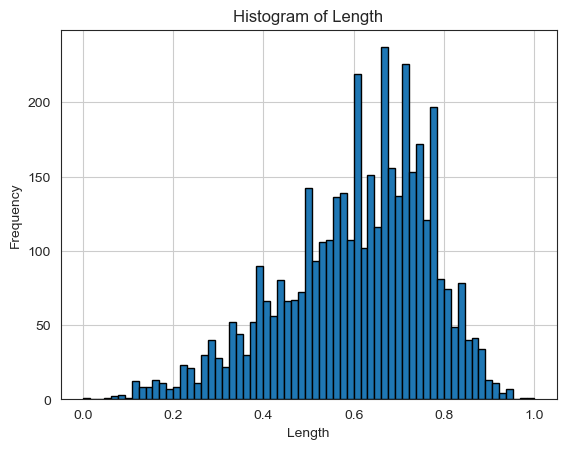

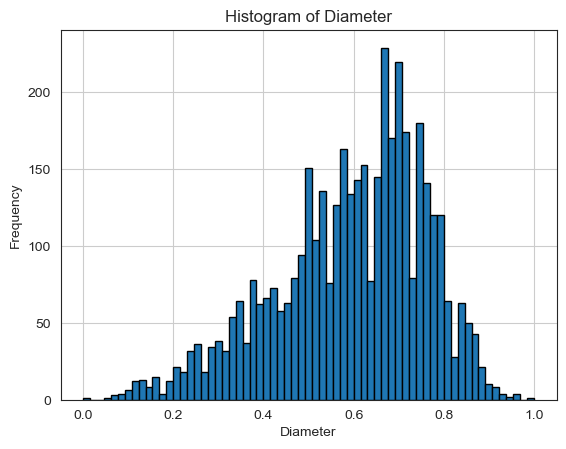

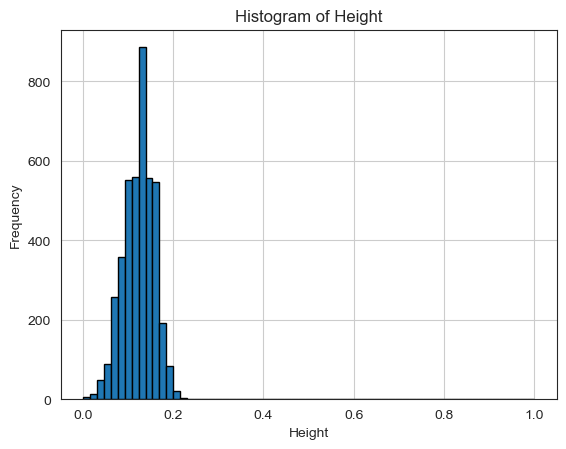

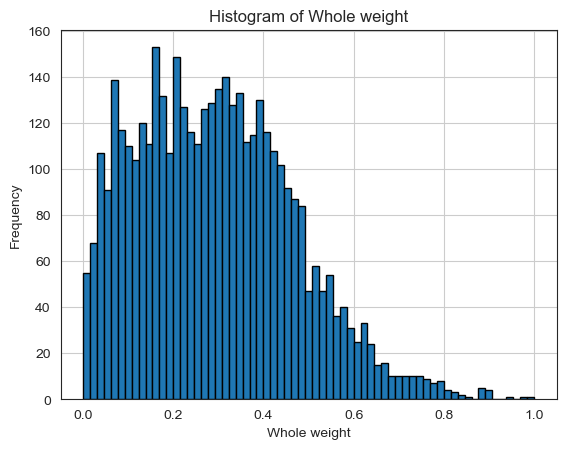

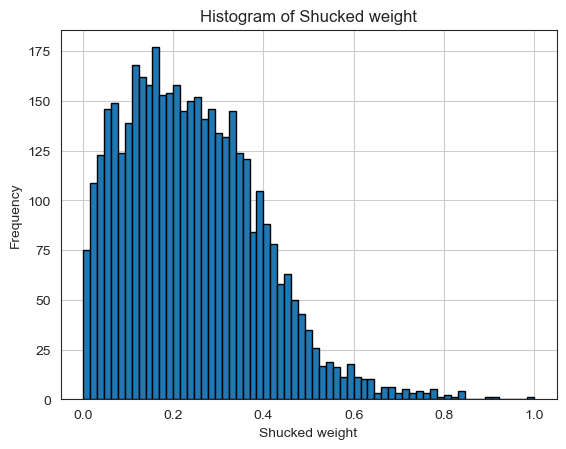

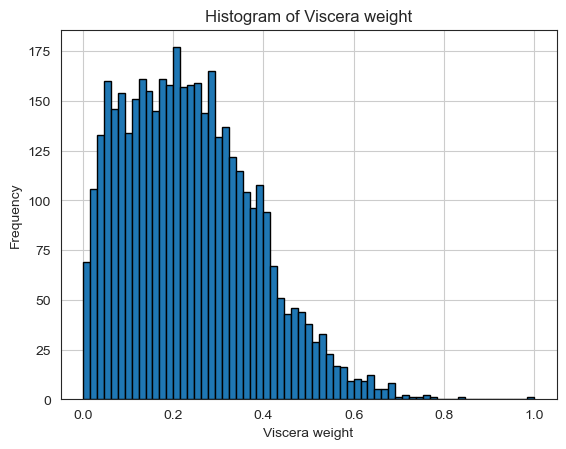

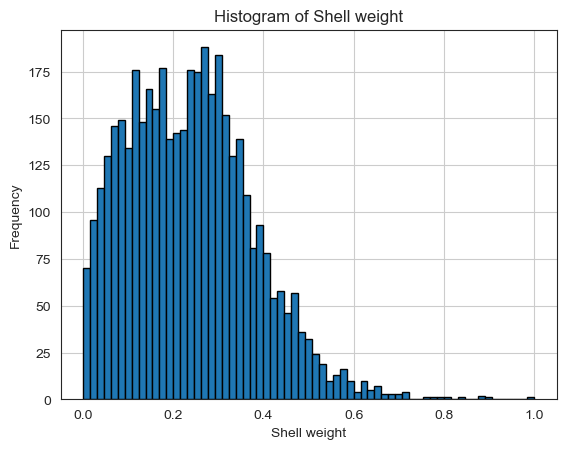

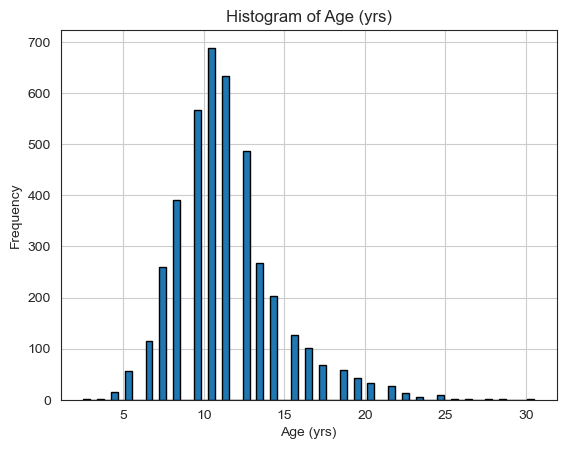

In [41]:
# vii) Plot bar charts for numerical variables.
import matplotlib.pyplot as plt
import numpy as np

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    plt.figure()
    plt.hist(data[column], bins=65, edgecolor='black')
    plt.title(f'Histogram of {column}')  
    plt.xlabel(column)  
    plt.ylabel('Frequency')
    plt.grid(True)  
    plt.show()  


### 2.2.2 K-Means Clustering(using sklearn)

In [43]:
# i) Construct model with k = 5

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# numerical variables
features = data.select_dtypes(include=['float64', 'int64']).values
one_hot_columns = data[['Sex_F', 'Sex_M', 'Sex_I']]
features = np.concatenate((features, one_hot_columns.values), axis=1)

# K-means model
kmeans = KMeans(n_clusters=5, random_state=42)

# fit model
kmeans.fit(features)


KMeans(n_clusters=5, random_state=42)

In [44]:
# ii) Compute and print silhouette coefficients

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features, kmeans.labels_)
print("Average Silhouette Coefficient:", silhouette_avg)

Average Silhouette Coefficient: 0.401351582985128


### 2.2.3 GMM and EM Algorithms

In [46]:
# i) Fit Gaussian Mixture Model with 2 Gaussians on [’Whole weights’] using EM Algorithm (choose number of iteration = 20).
import seaborn as sns
sns.set_style("white")

import matplotlib.pyplot as plt
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for data preprocessing
import pandas as pd
from math import sqrt, log, exp, pi
from random import uniform

# reference: https://www.kaggle.com/code/charel/learn-by-example-expectation-maximization/notebook
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

weight = data['Whole weight'].values

class GaussianMixture_self:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, weight, mu_min=min(weight), mu_max=max(weight), sigma_min=1, sigma_max=1, mix=.5):
        self.data = weight
        #todo the Algorithm would be numerical enhanced by normalizing the data first, next do all the EM steps and do the de-normalising at the end
        
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix = mix

    def Estep(self):
        "Perform an E(stimation)-step, assign each point to gaussian 1 or 2 with a percentage"
        # compute weights
        self.loglike = 0. # = log(p = 1)
        for datum in self.data:  
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix
            wp2 = self.two.pdf(datum) * (1. - self.mix)
            # compute denominator
            den = wp1 + wp2
            # normalize
            wp1 /= den   
            wp2 /= den     # wp1+wp2= 1, it either belongs to gaussian 1 or gaussion 2
            # add into loglike
            self.loglike += log(den) #freshening up self.loglike in the process
            # yield weight tuple
            yield (wp1, wp2)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, rigt) = zip(*weights) 
        one_den = sum(left)
        two_den = sum(rigt)

        # compute new means
        self.one.mu = sum(w * d  for (w, d) in zip(left, weight)) / one_den
        self.two.mu = sum(w * d  for (w, d) in zip(rigt, weight)) / two_den
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, weight)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(rigt, weight)) / two_den)
        # compute new mix
        self.mix = one_den / len(weight)

        
    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep()) #The heart of the algorith, perform E-stepand next M-step
            if verbose:
                print('{0:2} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike

    def pdf(self, x):
        return (self.mix)*self.one.pdf(x) + (1-self.mix)*self.two.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, mix={2.03})'.format(self.one, 
                                                              self.two, 
                                                              self.mix)

    def __str__(self):
        return 'Mixture: {0}, {1}, mix={2:.03})'.format(self.one, 
                                                        self.two, 
                                                        self.mix)

In [47]:
np.random.seed(123)

# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 4
best_mix = None
best_loglike = float('-inf')
for _ in range(n_random_restarts):
    mix = GaussianMixture_self(weight)
    for _ in range(n_iterations):
        try:
            mix.iterate()
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
#print('Best Gaussian Mixture : μ = {:.2}, σ = {:.2} with μ = {:.2}, σ = {:.2}'.format(best_mix.one.mu, best_mix.one.sigma, best_mix.two.mu, best_mix.two.sigma))

print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("1", best_mix.one.mu, best_mix.one.sigma, best_mix.mix))
print('Gaussian {:}: μ = {:.2}, σ = {:.2}, weight = {:.2}'.format("2", best_mix.two.mu, best_mix.two.sigma, (1-best_mix.mix)))

Gaussian 1: μ = 0.21, σ = 0.12, weight = 0.53
Gaussian 2: μ = 0.39, σ = 0.17, weight = 0.47


C:\Users\86183\AppData\Local\Temp\ipykernel_8960\2805582727.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weight, bins=20, kde=False, norm_hist=True);


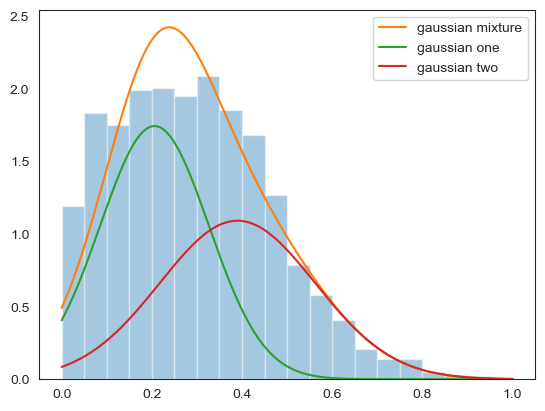

In [48]:
# ii) Plot fitted GMM
Min_graph = min(weight)
Max_graph = max(weight)
x = np.linspace(Min_graph, Max_graph, len(weight)) # to plot the data

sns.distplot(weight, bins=20, kde=False, norm_hist=True);
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
g_left = [best_mix.one.pdf(e) * best_mix.mix for e in x]
plt.plot(x, g_left, label='gaussian one');
g_right = [best_mix.two.pdf(e) * (1-best_mix.mix) for e in x]
plt.plot(x, g_right, label='gaussian two');
plt.legend();

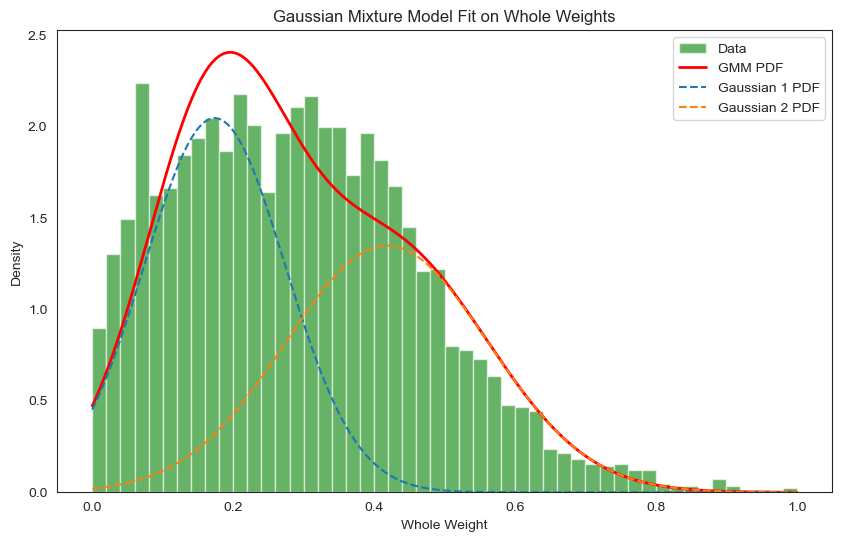

In [49]:
# iii) Now with the help of sklearn, fit GMM with 2 Gaussians on [’Whole weights’] again and Plot fitted GMM.

from sklearn.mixture import GaussianMixture

weight = weight.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(weight)

# gmm parameters
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# plot figure
plt.figure(figsize=(10, 6))
plt.hist(weight, bins=50, density=True, alpha=0.6, color='g', label='Data')
x = np.linspace(min(weight), max(weight), 1000)

# pdf
pdf_values = np.exp(gmm.score_samples(x.reshape(-1, 1)))
# plot pdf
plt.plot(x, pdf_values, label='GMM PDF', color='r', linewidth=2)

# pdf for each gaussian
for i in range(2):
    mean = means[i][0]
    std = np.sqrt(covariances[i][0][0])
    weight = weights[i]
    gaussian_pdf = weight * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    plt.plot(x, gaussian_pdf, linestyle='--', label=f'Gaussian {i+1} PDF')

plt.title('Gaussian Mixture Model Fit on Whole Weights')
plt.xlabel('Whole Weight')
plt.ylabel('Density')
plt.legend()
plt.show()

In [50]:
# Prepare the data (all predictors)
# Create and fit the Gaussian Mixture Model

gmm = GaussianMixture(n_components=2, max_iter=20, random_state=42)
gmm.fit(features)

GaussianMixture(max_iter=20, n_components=2, random_state=42)

In [51]:
weight = data['Whole weight'].values.reshape(-1,1)
# print(weight)

gmm = GaussianMixture(n_components=2, max_iter=20, random_state=42)
gmm.fit(weight)

silhouette_avg = silhouette_score(weight, gmm.predict(weight))
print("Average Silhouette Coefficient:", silhouette_avg)

print("\nIn K-means clustering, the average silhouette score is 0.401351582985128. In GMM and EM algorithm, the average silhouette score is 0.2216884597405814. Based on the average silhouette scores, I would prefer K-means clustering over GMM for this dataset. The K-means clustering achieved a higher silhouette score of 0.3586, indicating better cluster separation and more distinct clusters compared to the lower score of 0.2217 for GMM. This suggests that K-means is more effective at organizing the data into meaningful clusters. Additionally, K-means is simpler and more interpretable, which makes it easier to understand the results, particularly when the data form spherical clusters. Overall, the results indicate that K-means aligns better with the data distribution in this case, making it the more suitable choice for clustering.")


Average Silhouette Coefficient: 0.5814437564240167

In K-means clustering, the average silhouette score is 0.401351582985128. In GMM and EM algorithm, the average silhouette score is 0.2216884597405814. Based on the average silhouette scores, I would prefer K-means clustering over GMM for this dataset. The K-means clustering achieved a higher silhouette score of 0.3586, indicating better cluster separation and more distinct clusters compared to the lower score of 0.2217 for GMM. This suggests that K-means is more effective at organizing the data into meaningful clusters. Additionally, K-means is simpler and more interpretable, which makes it easier to understand the results, particularly when the data form spherical clusters. Overall, the results indicate that K-means aligns better with the data distribution in this case, making it the more suitable choice for clustering.
